## 1. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

# 모델 수립을 위한 Train/Validation Set
df = pd.read_csv('./ADX/Data_P2P/P2_dataset.csv', encoding ='cp949') 


Mounted at /content/drive
/content/drive/My Drive
cp: cannot open 'ADX/5주차_중간/P1_data_modified_note.gsheet' for reading: Operation not supported


## 2. Modelling
- df를 사용하여 예측모형 수립
- Feature engineering에 대한 토의/구현 진행
- Computation time을 고려하여 전체 데이터를 완전히 사용하지 말고 Sampling하여 Model Train/Vadliation을 진행하는 것을 추천
- Sampling을 단 한번 한 것으로 모형 Train 한 것이 과연 옳은 것인지에 대해 팀원들과 고민해볼 것. 해결 방법은 없을지 서치해보는 것도 하나의 task임.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2.1 EDA구현

<ipython-input-3-39e39c2d9d07>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

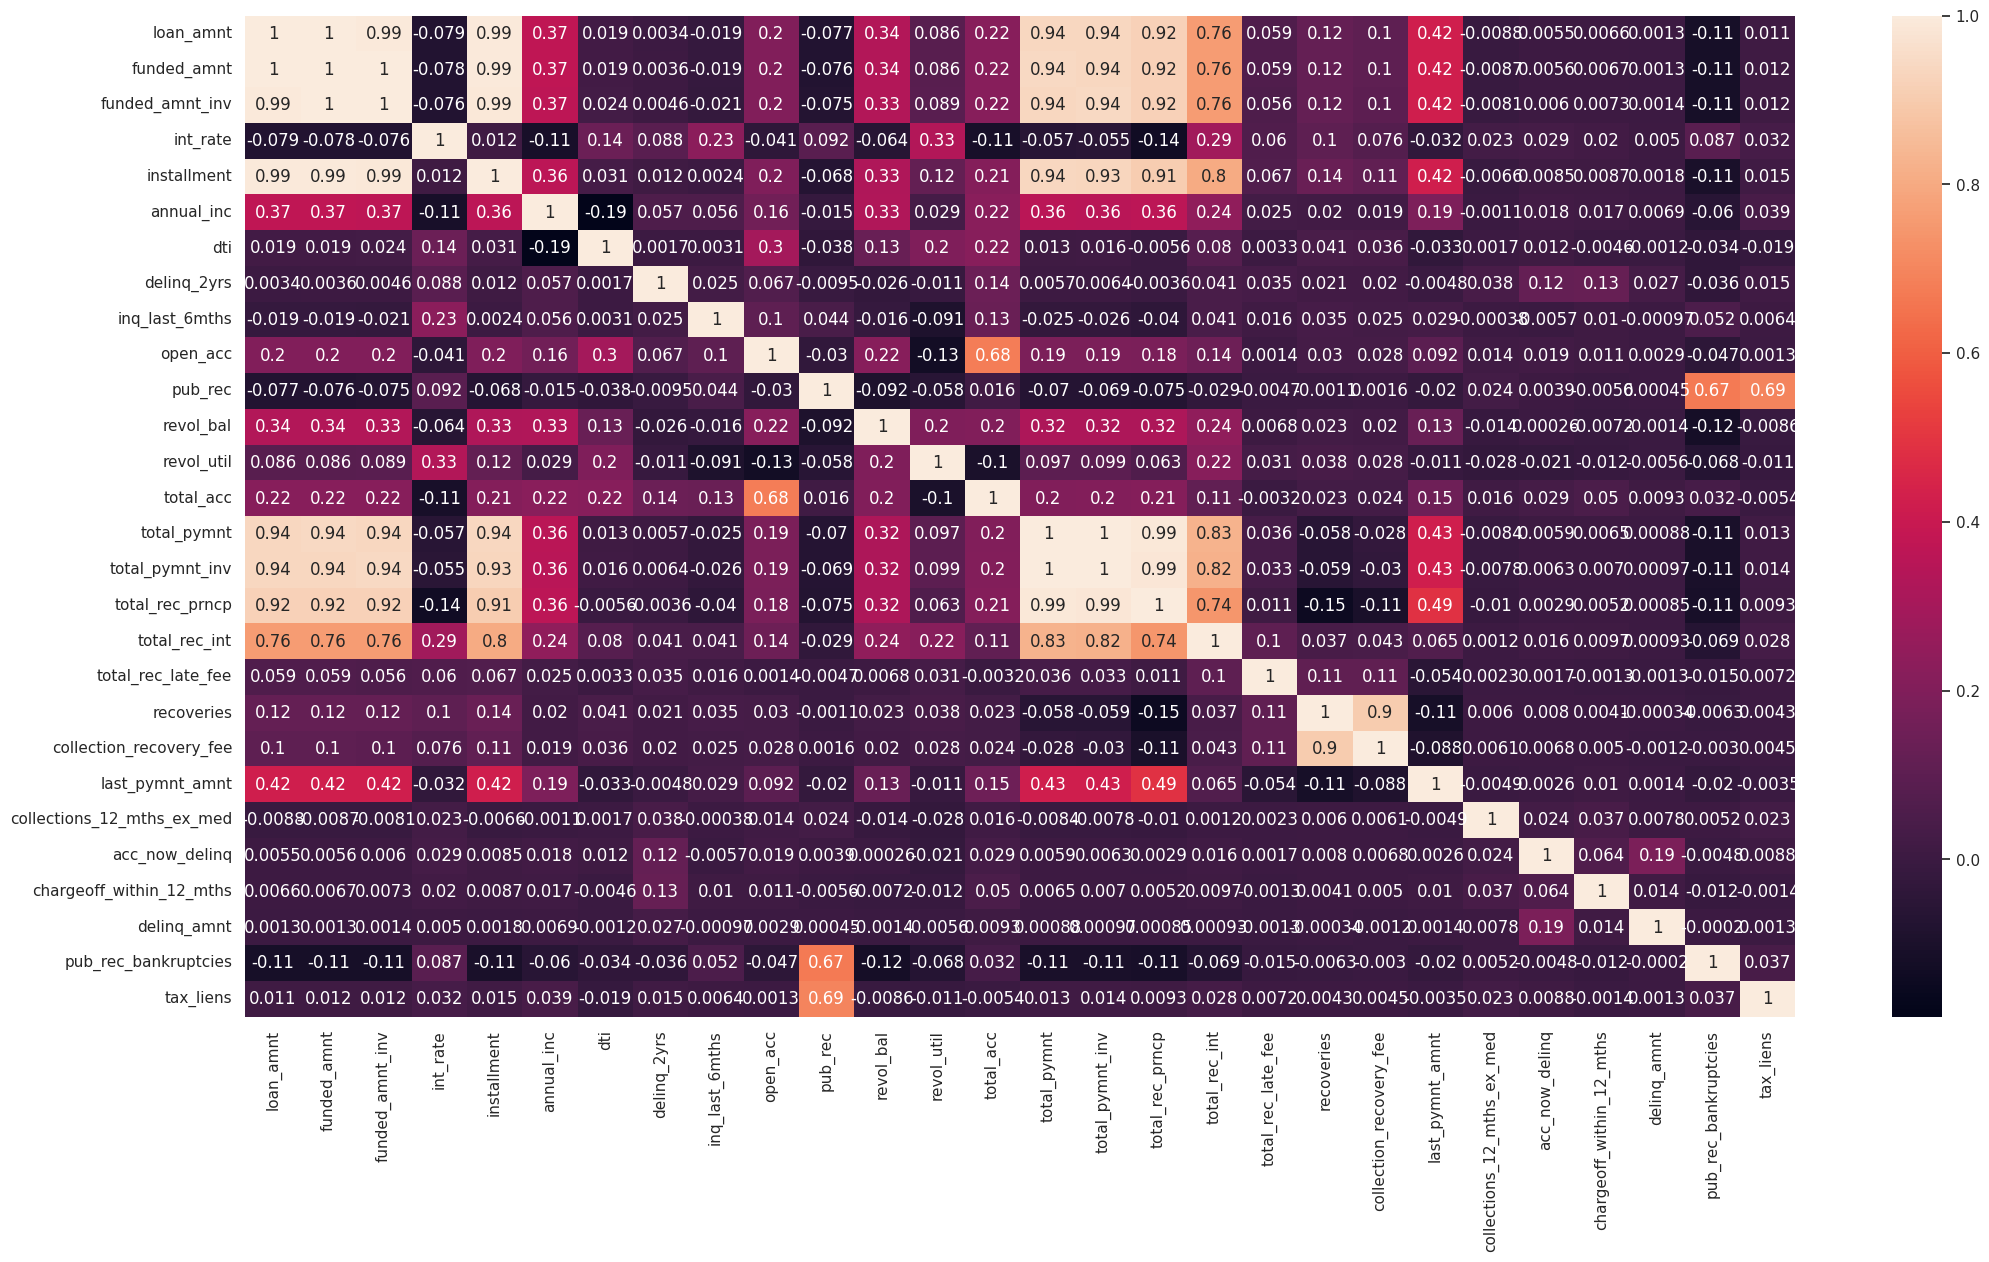

In [ ]:
# 수치형 변수간의 상관 관계를 파악하여 다중공선성, overfitting 방지
sns.set(rc = {'figure.figsize':(25,13)})
sns.heatmap(df.corr(),annot=True)

#### 1. 반응변수가 불균형 변수인지 먼저 파악 b/c y가 불균형 데이터인지 파악(efsvm은 불균형 데이터에 fit한 model이므로)

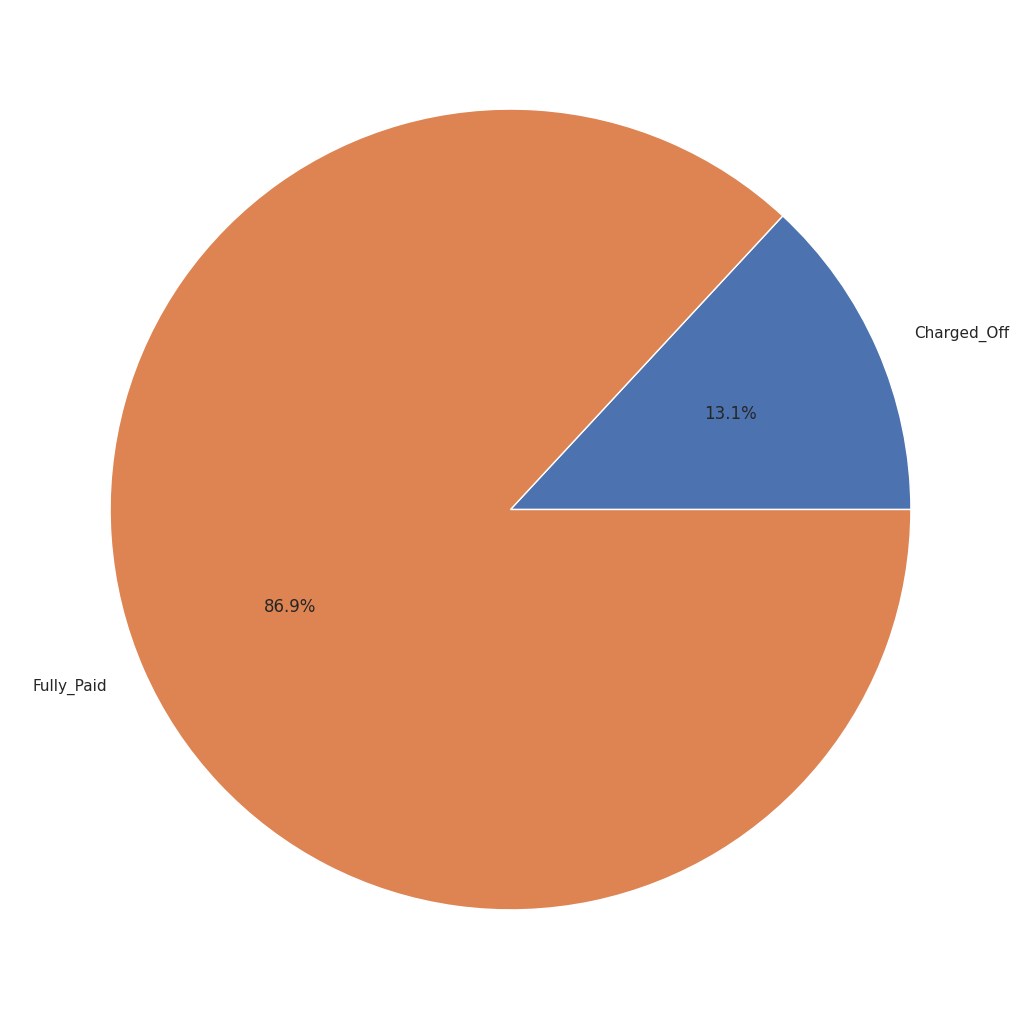

In [ ]:
### 역시 미납된 것이 더 적음(불균형 데이터) -> 이것을 positive class로 잡고 구현을 진행함.
co = 0 
for i in range(df['loan_status'].shape[0]):
  if df['loan_status'][i] == 'Charged Off':
    co += 1

ratio = [co / df['loan_status'].shape[0], 1 - co / df['loan_status'].shape[0]] # 두 label에 대한 분포 정도를 계산해서 pie chart로 도식화해 데이터 형태를 살펴봄
labels = ['Charged_Off', 'Fully_Paid']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show() # imbalance dataset임을 확인할 수 있음.


### 2.2 Feature Engineering

In [ ]:
# 결측치 처리하고나서 인코딩 진행
# 수치형 변수는 mean, 범주형 변수는 최빈값(feature engineering에서 처리하였음)으로 처리하였다.
# 결측치가 존재하는 수치형 변수
col = ['revol_util','collections_12_mths_ex_med','chargeoff_within_12_mths','pub_rec_bankruptcies','tax_liens'] 

for i in col:
  df[i].replace(np.nan, df[i].mean(), inplace = True)

In [ ]:
#Feature Engineering

def feature_engin(data):
    check_emp_length = [np.nan, '10+ years'] # emp_length의 최빈값은 10+ years

    # loan_amnt를 사용하고, funded_amnt와 funded_amnt_inv col 삭제(다중공선성, 상관관계가 매우 높음을 확인)
    data.drop(labels = ['funded_amnt', 'funded_amnt_inv'], axis = 1, inplace = True)
    
    # 세부 등급은 삭제, grade만 사용(인코딩 실시 A:7 ~ G :0)
    data.drop(labels = ['sub_grade'], axis = 1, inplace = True)
    grade_map = {'A' : 6, 'B' : 5, 'C' : 4, 'D' : 3, 'E' : 2, 'F' : 1, 'G' : 0}
    data['grade'] = data['grade'].map(grade_map)

    #home ownership의 경우 mortgage가 가장 Chargedoff 비율이 낮음 
    #mortgage 3, own 2, rent 1, other 0 할당
    home_map = {'MORTGAGE' : 4, 'OWN' : 3, 'RENT' : 2, 'NONE' : 1, 'OTHER' : 0, 'ANY' : 0}
    data['home_ownership'] = data['home_ownership'].map(home_map)

    #emp_length의 경우 10+ years에서 가장 낮은 charged-off 비율을 확인함
    # 10년 이상과 아닌 것으로 one-hot encoding 실시(10년 이상 :1, 그외 0)
    data['emp_length'] = data['emp_length'].apply(lambda x:1 if x in check_emp_length  else 0)

    #verification status의 경우 not verified 2, source verified 1, verified 0 부여
    veri_map = {'Not Verified' : 2, 'Source Verified' : 1, 'Verified' : 0}
    data['verification_status'] = data['verification_status'].map(veri_map)

    #purpose의 경우 종류가 많아, 5% 넘는 것들에 대해 고려
    #credit이 전체의 23%이고, Charged_off 비율이 11.0%로 준수하기에 3 부여
    #home_improvement와 wedding은 각각 5%이고, charged off 비율역시 11% 초반이기에 2부여
    #debt_consolidation의 경우 전체의 50%이상을 차지하고, charged off 비율이 13.5% 정도, 1부여
    #나머지는 비율이 너무 작아 0 부여
    data['purpose'] = data['purpose'].apply(purpose_encoder)

    #(total_rec_prncp+total_rec_int) / annual_inc 를 이용하여 dsr이라는 새로운 feature 생성
    #total_rec+prncp와 total_rec_int는 삭제
    data['dsr'] = (data['total_rec_prncp']+ data['total_rec_int'])/data['annual_inc']
    data.drop(labels = ['total_rec_prncp', 'total_rec_int'], axis = 1, inplace = True)

    #initial_list_status 의 경우 chargedoff 비율이 w, f 두 경우에 같게 나와 무의미하다고 판단
    data.drop('initial_list_status', axis = 1, inplace = True)

    #recoveries와 collection_recovery_fee를 더해 recovery라는 column으로 변경
    data['recovery'] = data['recoveries'] + data['collection_recovery_fee']
    data.drop(labels = ['recoveries', 'collection_recovery_fee'], axis = 1, inplace = True)

    data['loan_status'] = data['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else -1)

    return data # 전처리 완료한 데이터 return


def purpose_encoder(x):
    if x == 'credit_card':
        return 3
    elif x == 'home_improvement' or 'wedding':
        return 2
    elif x == 'debt_consolidation':
        return 1
    else:
        return 0

In [ ]:
df1 = feature_engin(df) # 데이터 전처리

In [ ]:
df1.isna().sum() # 결측치가 모두 처리 되었음을 확인

loan_amnt                     0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
total_pymnt                   0
total_pymnt_inv               0
total_rec_late_fee            0
last_pymnt_amnt               0
collections_12_mths_ex_med    0
acc_now_delinq                0
chargeoff_within_12_mths      0
delinq_amnt                   0
pub_rec_bankruptcies          0
tax_liens                     0
dsr                           0
recovery                      0
dtype: int64

In [ ]:
y = df1['loan_status']
X = df1.drop('loan_status', axis = 1)

### 2.3 Feature Selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

In [ ]:
#lgbm classifier를 이용하여 feature selection 진행

lgbm = LGBMClassifier(random_state = 34)
cv=5
selector2 = RFECV(lgbm, cv = cv, verbose = 2)
selector2.fit(X,y)

print("Optimal number of features : %d" % selector2.n_features_)
print()
print('feture selected: ', selector2.get_feature_names_out())

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


<Axes: >

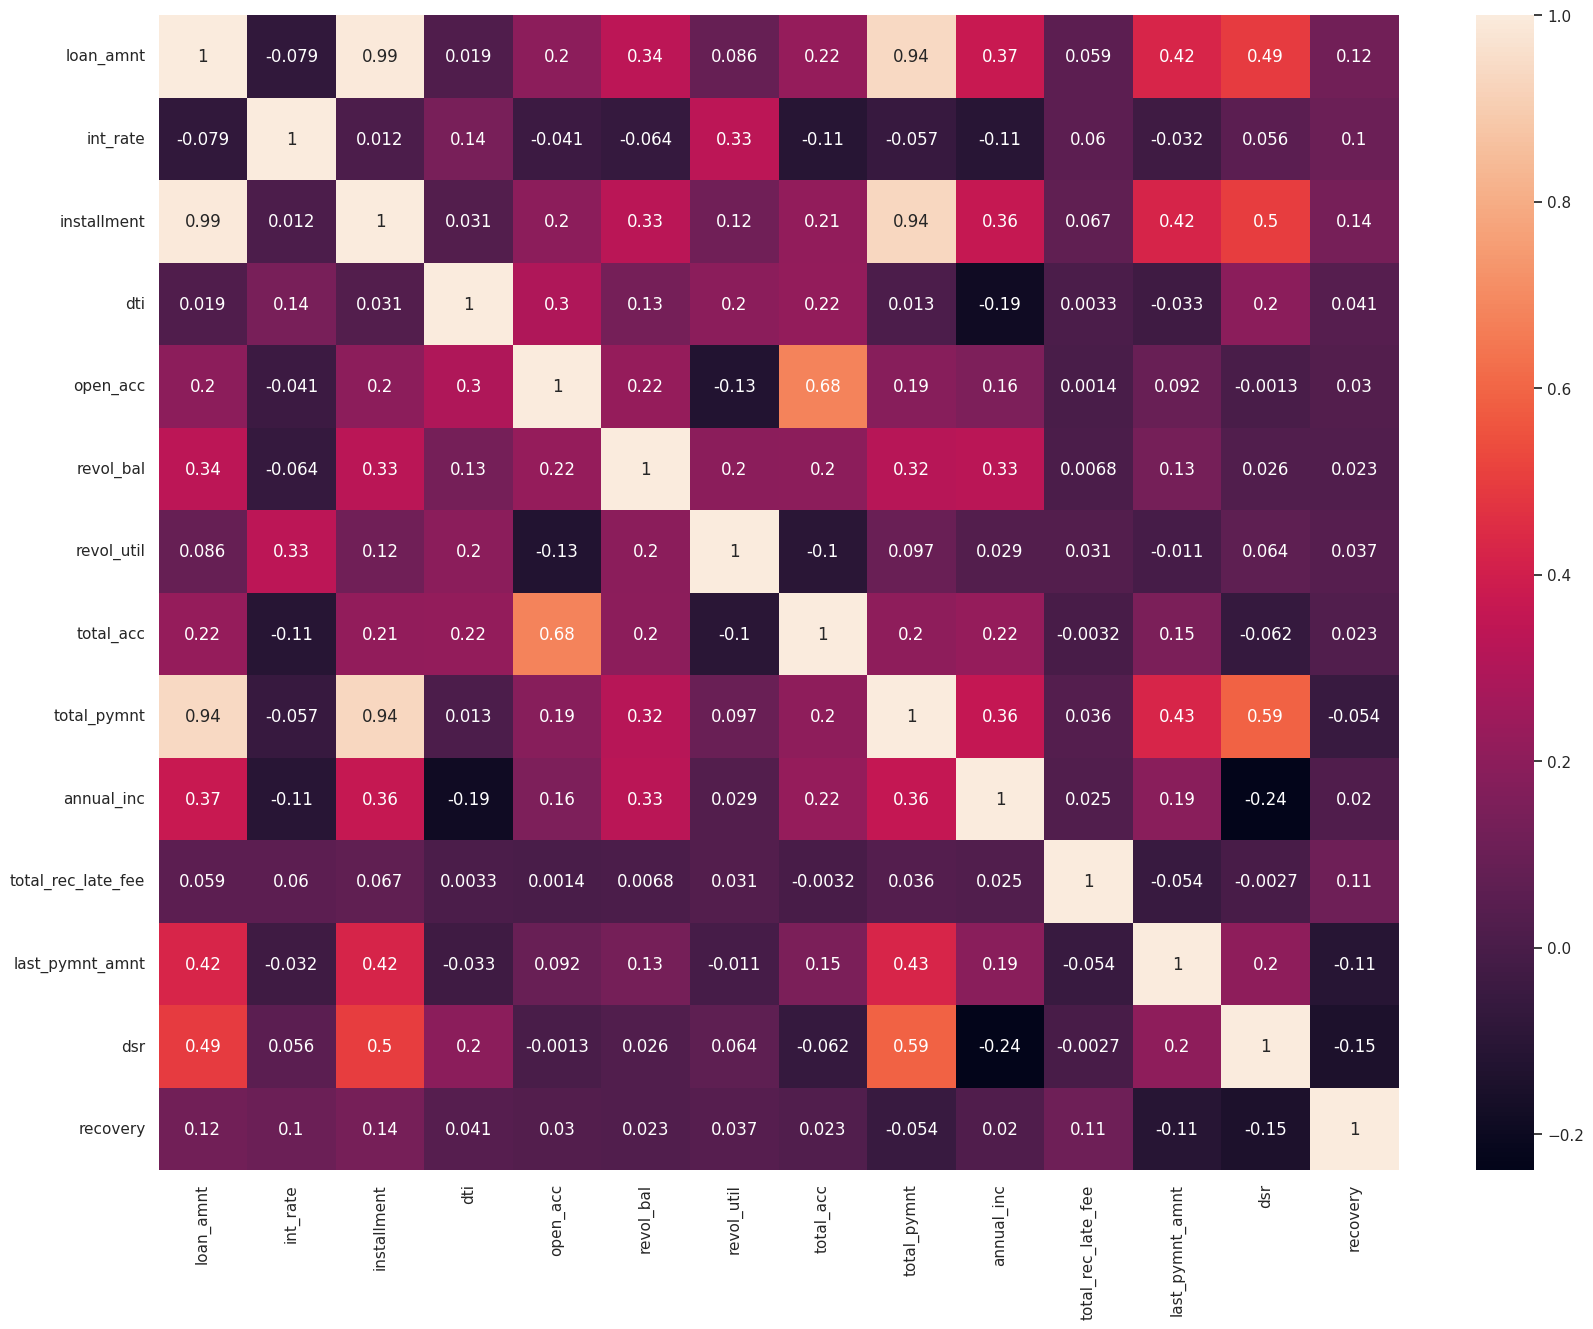

In [ ]:
#여러번 반복 수행 후, 반복적으로 나온 feature만 선택
#total_pymt_inv의 경우, 'total_pymt'와 correlation이 1이라서 선택하지 않음
data_chosen = X[['loan_amnt', 'int_rate', 'installment', 'dti', 'open_acc', 'revol_bal',
 'revol_util', 'total_acc', 'total_pymnt','annual_inc', 
 'total_rec_late_fee', 'last_pymnt_amnt', 'dsr', 'recovery']]
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(data_chosen.corr(),annot=True)

### 2.4 Hyper-Parameter Tuning

In [ ]:
def Kernel_(x, y, params = 0, type_ = 'default') : # kernel trick을 위한 function
    if type_ == 'rbf' :
      Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
      return Kernel
    elif type_ == 'default' :
      Kernel = np.dot(x, y.T)
      return Kernel

def Minmax_(X) : # min max scaling
    return (X - X.min(axis = 0)) / (X.max(axis= 0) - X.min(axis = 0)), X.max(axis =0) , X.min(axis =0)

def Standar_(X) : # z - normalize
    return (X - X.mean(axis =0)) / X.std(axis = 0), X.mean(axis =0), X.std(axis = 0)

def LogScale_(X): # log scaling
  return np.log1p(X)

def test_Standar_(X, cache): # test data의 정규화를 위해 캐시를 사용(cache hit)
  return (X - cache['mean']) / cache['std']

def test_Minmax_(X, cache): # test data를 cache로 scaling
  return (X - cache['min'])/(cache['max']-cache['min'])

def Convolution(pred, real) :
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN
    
# f1-score
def f1_score(X):
  TP, FP, FN, TN = X
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  return (Precision * Recall) * 2 / (Precision + Recall)

# accuracy, precision, recall return
def acc_precision_recall(X) :
  TP,FP,FN,TN = X
  return (TP + TN) / (TP + FP + FN + TN), TP / (TP + FP), TP / (TP + FN)


전체 데이터를 사용하는 것은 불가능하다고 판단
데이터를 y의 비율에 맞춰 20세트로 나눈 후, 임의 5세트를 선택하여
1개는 하이퍼 파라미터 튜닝용, 4개는 모델 학습용으로 선정

In [ ]:
skf = StratifiedKFold(n_splits = 50)

index_list = []
for test_index in skf.split(data_chosen, y):
    index_list.append(test_index[1].tolist())

for i in range(len(index_list)):
  globals()["data_X{}".format(i+1)] = data_chosen.iloc[index_list[i]]
  globals()["data_y{}".format(i+1)] = y.iloc[index_list[i]]

In [ ]:
data_X1

,loan_amnt,int_rate,installment,dti,open_acc,revol_bal,revol_util,total_acc,total_pymnt,annual_inc,total_rec_late_fee,last_pymnt_amnt,dsr,recovery
0,8000,0.1757,287.50,12.66,9,4445,0.397,20,9603.600000,93000.0,0.00,287.50,0.102315,104.1586
1,31900,0.1335,1080.23,0.63,10,4117,0.142,24,22219.170000,250000.0,54.01,2214.47,0.082097,1936.1322
2,1500,0.1757,53.91,23.40,31,11606,0.835,66,1183.090000,60000.0,0.00,53.91,0.019718,0.0000
3,10000,0.1777,360.38,3.50,7,4917,0.410,12,2883.040000,50000.0,0.00,360.38,0.057661,0.0000
4,24000,0.1849,873.57,18.67,15,39227,0.956,29,19124.890000,100000.0,43.68,1258.98,0.190738,7.3600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47462,4000,0.1261,134.03,18.36,13,8626,0.607,20,4736.331330,54000.0,0.00,1528.69,0.087710,0.0000
47463,7750,0.1561,270.98,12.32,7,1181,0.232,16,9103.530003,30000.0,0.00,593.73,0.303451,0.0000
47464,10000,0.0542,301.60,10.24,11,17222,0.195,34,10858.571030,120000.0,0.00,329.08,0.090488,0.0000
47465,5000,0.1249,167.25,25.86,11,9293,0.340,29,5831.680000,80000.0,0.00,2486.68,0.072896,0.0000


In [ ]:
data_y1

0        1
1        1
2        1
3        1
4        1
        ..
47462   -1
47463   -1
47464   -1
47465   -1
47466   -1
Name: loan_status, Length: 6398, dtype: int64

In [ ]:
# 8, 11, 17번세트를 모델 학습용으로 사용
train_X1 = data_X8
train_X2 = data_X11
train_X3 = data_X17

train_y1 = data_y8
train_y2 = data_y11
train_y3 = data_y17

In [ ]:
def df_change(df_train, df_test, tr_y, t_y):
  # 정규화하기 위한 함수, dataframe의 scaling과 type변환 진행
  std_col = [ 'int_rate', 'installment', 'dti', 'open_acc', 'revol_util', 'total_acc', 'dsr'] # z-normalize 할 features
  log_col = ['loan_amnt' ,'revol_bal', 'total_pymnt', 'annual_inc', 'total_rec_late_fee','last_pymnt_amnt', 'recovery'] # log scaling 할 features
  std_X = df_train[std_col] # std_col 해당 데이터들
  log_X = df_train[log_col] # log_col 해당 데이터들

  tr_X1 = Standar_(np.array(std_X))[0] # z-normalize
  tr_X2 = LogScale_(np.array(log_X)) # log-scaling

  z_cache = {'mean':Standar_(np.array(std_X))[1], 'std':Standar_(np.array(std_X))[2]} # z-normalize cache 저장
  l_cache = {}
  train_X = np.array(np.concatenate([tr_X1, tr_X2], axis=1))

  # test data도 위처럼 동일하게 진행, 이는 normalize할 때 cache를 가지고 진행
  std_tX = df_test[std_col] 
  log_tX = df_test[log_col]
  tX1 = test_Standar_(np.array(std_tX), z_cache)
  tX2 = LogScale_(np.array(log_tX))
  test_X = np.array(np.concatenate([tX1, tX2], axis=1))
  
  # 반응 변수 데이터들은 타입을 맞추고자 이렇게 연산을 진행
  train_y = np.array(tr_y)*1.
  test_y = np.array(t_y)*1. 
  
  return train_X, test_X, train_y, test_y

In [ ]:
# test set을 위한 cache 저장, 이용할 세 train data들의 평균, std를 묶어 cache로 사용할 것임
std_col = ['int_rate', 'installment', 'dti', 'open_acc', 'revol_util', 'total_acc', 'dsr']
train_X = pd.concat([train_X1, train_X2, train_X3])
z_cache = {'mean':train_X[std_col].mean(), 'std':train_X[std_col].std()}

In [ ]:
## 3개의 개별 모델에 3개의 학습 데이터셋을 각각 집어 넣어, 하이퍼 파라미터 튜닝 및 학습 진행
## 후 voting 기법을 이용하여 최종 모델을 구현
## 스케일링과 형 변환 실시
trX1, tX1, try1, ty1 = train_test_split(train_X1, train_y1, test_size = 0.25, random_state = 34)
trX2, tX2, try2, ty2 = train_test_split(train_X2, train_y2, test_size = 0.25, random_state = 34)
trX3, tX3, try3, ty3 = train_test_split(train_X3, train_y3, test_size = 0.25, random_state = 34)

trX1, tX1, try1, ty1= df_change(trX1, tX1, try1, ty1)
trX2, tX2, try2, ty2= df_change(trX2, tX2, try2, ty2)
trX3, tX3, try3, ty3= df_change(trX3, tX3, try3, ty3)

In [ ]:
# convex optimization 활용 및 entropy fuzzy 구현을 위한 library import
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from scipy.stats import entropy
from scipy.spatial import distance

In [ ]:
# SVM class
class new_SVM:
  def __init__(self, C, gamma = 0, type_ = 'default'):
    self.gamma = gamma
    self.type_ = type_
    self.C = C # 튜닝할 parameter
    self.kernel = None
    self.X = None # 학습 데이터
    self.y = None # 학습 y
    self.alphas = None # 구한 alphas
    self.S = None # 구한 S
    self.w = None # 구한 w
    self.b = None # 구한 b

  # 커널 함수
  def Kernel_(self, x, y, params = 0, type_ = 'default') :
      Kernel = None
      if type_ == 'rbf' :
        Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
      elif type_ == 'default' :
        Kernel = np.dot(x, y.T)
      
      self.kernel = Kernel
      return Kernel

  # convex optimization에 필요한 parameter들을 반환
  def getArgs(self, X, y):
    Kernel = self.Kernel_(X, X, self.gamma, self.type_)

    y = y.reshape(-1,1) 
    self.y = y 
    m,n = X.shape

    H = self.kernel * 1.
    H *= y @ y.T

    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    return P, q, G, h, A, b

  # train data를 이용해서 convex optimization을 통해 모델을 학습
  def solver(self, X, y):
    self.X = X
    self.y = y
    P, q, G, h, A, b = self.getArgs(self.X, self.y)
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)

    alphas = np.array(sol['x'])
    self.alphas = alphas 

    if self.type_ == 'default': # linear kernel
      w = ((self.y * self.alphas).T @ self.X).reshape(-1, 1)
    else: # gaussian kernel
      w = None # rbf는 w 출력 불가
    S = ((self.alphas > 1e-4) & (self.alphas < self.C-1e-4)).flatten()
    if self.type_ == 'rbf': # gaussian kernel
      b = self.y[S] - np.sum(self.Kernel_(self.X, self.X[S], self.gamma, self.type_) * self.y * self.alphas, axis = 0).reshape(-1, 1) # rbf의 경우 b를 출력
    else: # linear kernel
      b = self.y[S] - np.sum(self.Kernel_(self.X, self.X[S]) * self.y * self.alphas, axis = 0).reshape(-1, 1) # linear의 경우

    self.w = w
    self.S = S
    self.b = b

    return alphas, S, w, b

  # t_A: test(validation)할 데이터, 학습한 모델에 투입해 분류 결과를 return
  def predict(self, t_A):
    pred_sol = np.sign(np.sum(self.Kernel_(self.X, t_A, self.gamma, self.type_) * self.y * self.alphas, axis = 0).reshape(-1,1) + self.b[0])
    return pred_sol




In [ ]:
# EFSVM class
class new_EFSVM:
  def __init__(self, C, beta, k, m, gamma = 0, type_ = 'default'):
    self.gamma = gamma
    self.type_ = type_
    self.C = C # 튜닝할 parameter
    self.beta = beta # 튜닝할 parameter
    self.k = k # 튜닝할 parameter
    self.m = m # 튜닝할 parameter
    self.kernel = None
    self.X = None # 학습 데이터
    self.y = None # 학습 y
    self.alphas = None # 구한 alphas
    self.S = None # 구한 S
    self.w = None # 구한 w
    self.b = None # 구한 b
    self.support = None 
    self.entr = None # 구한 엔트로피
    self.membership = None # 구한 fuzzy membership
    self.si_array = None # 구한 s_i

  # 커널 함수, kernel trick의 적용을 위함
  def Kernel_(self, x, y, params = 0, type_ = 'default') :
      Kernel = None
      if type_ == 'rbf' :
        Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
      elif type_ == 'default' :
        Kernel = np.dot(x, y.T)
      
      self.kernel = Kernel
      return Kernel
  

  # 유클리드 거리 계산
  def getDist(self, X):
    return distance.cdist(X, X, metric = 'euclidean')


  #2 엔트로피를 받아오는 것
  def getEntropy(self, X, y, k):
      Distance = self.getDist(X) # 유클리드 거리를 저장
      knn_neg = [np.argsort(Distance[idx])[1:k+1] for idx, val in enumerate(y) if val < 0] # negative class 주변의 인접한 k개의 점들의 인덱스를 거리 순으로 정렬해 저장
      Entropy = [] # 엔트로피 저장 list
      for indexs in knn_neg:
          p_cnt = len([y[idx] for idx in indexs if y[idx] > 0]) # 현재 negative class의 주변에 있는 positive class의 개수
          pr_pos = p_cnt / k # positive 확률
          pr_neg = 1 - pr_pos # negative 확률
          H_i = entropy([pr_pos, pr_neg]) # 엔트로피 계산
          Entropy.append(H_i) # 엔트로피 list append

      return Entropy # 엔트로피 return

  #3 EF를 계산 -> 논리상 정렬 없이 구현 가능 (by brute force)
  def EFMember(self, Entropy, m, beta):
    H_min = min(Entropy) # minimum H
    H_max = max(Entropy) # maximum H

    sub = {}
    for l in range(1, m + 1):
        thrUp = H_min + (H_max - H_min)*(l / m)
        thrLow = H_min + (H_max - H_min)* (l - 1) / m
        
        temp = []
        for i, H in enumerate(Entropy): 
            cond = (thrLow <= H and thrUp >= H) if l == m else (thrLow <= H and thrUp > H)
            if cond: # 조건에 만족하는 엔트로피는 그 인덱스를 list에 저장
                temp.append(i)

        if len(temp) == 0: # 조건에 만족한 엔트로피가 없다면, FM계산 없이 넘어가기
          continue

        fm = 1.0 - beta * l # 해당되는 fuzzy membership value
        sub[fm] = temp # 해당하는 점들을 FM값으로 그룹핑(key: FM, value: 해당되는 점들(인덱스))
   
    return sub

  #4 s_i 계산
  def getsi(self, X, FM, y):
    si = [] #s_i를 저장하는 list
    neg_class = [idx for idx, val in enumerate(y) if val < 0] # negative class들의 인덱스

    for i in range(len(y)): # 모든 반응변수에 대해 iteration
      if i in neg_class: # negative class는 해당되는 fuzzy membership이 s_i
        for j in FM:
          if neg_class.index(i) in FM[j]: # .index(i)로 참조해야 올바르게 FM[j]에서 값을 참조할 수 있음
            si.append(j)
            break
      else: # positive class는 s_i가 1
        si.append(1.0)
      
    return si

# convex optimization에 필요한 parameter들을 반환
  def getArgs(self, X, y):
    Kernel = self.Kernel_(X, X, self.gamma, self.type_)

    entr = self.getEntropy(X, y, self.k)
    self.entr = entr

    membership = self.EFMember(entr, self.m, self.beta)
    self.membership = membership

    si_array = np.array(self.getsi(X, self.membership, y))
    self.si_array = si_array

    y = y.reshape(-1,1)
    self.y = y 
    m,n = X.shape

    H = self.kernel * 1.
    H *= y @ y.T

    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * self.si_array * self.C))) # s_i를 추가적으로 이용
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    return P, q, G, h, A, b

  # train data를 이용해서 convex optimization을 통해 모델을 학습
  def solver(self, X, y):
    self.X = X
    self.y = y
    P, q, G, h, A, b = self.getArgs(self.X, self.y)
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)

    alphas = np.array(sol['x'])
    self.alphas = alphas

    if self.type_ == 'default':
      w = ((self.y * self.alphas).T @ self.X).reshape(-1, 1)
    else:
      w = None # rbf는 w 출력 불가
    S = ((self.alphas > 1e-4) & (self.alphas < self.C-1e-4)).flatten()
    if self.type_ == 'rbf':
      b = self.y[S] - np.sum(self.Kernel_(self.X, self.X[S], self.gamma, self.type_) * self.y * self.alphas, axis = 0).reshape(-1, 1) # rbf의 경우 b를 출력
    else:
      b = self.y[S] - np.sum(self.Kernel_(self.X, self.X[S]) * self.y * self.alphas, axis = 0).reshape(-1, 1) # linear의 경우

    self.w = w
    self.S = S
    self.b = b

    return alphas, S, w, b
# t_A: test(validation)할 데이터, 학습한 모델에 투입해 분류 결과를 return
  def predict(self, t_A):
    pred_sol = np.sign(np.sum(self.Kernel_(self.X, t_A, self.gamma, self.type_) * self.y * self.alphas, axis = 0).reshape(-1,1) + self.b[0])
    return pred_sol


In [ ]:
#1번 모델 하이퍼 파라미터 튜닝 및 객체화
#데이터 셋 1번을 이용.

rbfef_hyper_value = [0, 0, 0, 0] # acc, prec, recall, f1-score
rbfef_c = 0 # 튜닝한 파라미터 c를 저장해둠
rbfef_k = 0
rbfef_beta = 0
rbfef_m = 0
rbfef_gamma = 0
best_rbfef_1 = None # best model in train1

c_val = 25
ks = [5, 10]
m_val = 10
betas = [0.05, 0.1]
gammas = [0.01, 0.1]

for k_val in ks:
  for beta_val in betas:
    for gamma_val in gammas:
      rbfef_svm = new_EFSVM(c_val, beta_val, k_val, m_val, gamma_val, type_ = 'rbf')
      rbfef_svm.solver(trX1, try1) # 학습 시킬 데이터 여기에 넣기
      y_pred = rbfef_svm.predict(tX1) # test data(validation data) -> 결과값의 예측이 진행 됨

      current_acc, current_prec, current_recall = acc_precision_recall(Convolution(y_pred.flatten(), ty1)) # 정확성 정밀도 재현율 반환됨
      current_f1_score = f1_score(Convolution(y_pred.flatten(), ty1)) # f1-score
      print(current_acc, current_prec, current_recall)

      # 파라미터 튜닝할 때의 기준치
      if rbfef_hyper_value[3] < current_f1_score:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_1 = rbfef_svm

      elif rbfef_hyper_value[2] < current_recall:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_1 = rbfef_svm

      elif rbfef_hyper_value[1] < current_prec:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_1 = rbfef_svm


     pcost       dcost       gap    pres   dres
 0:  1.1681e+04 -1.1374e+06  3e+06  4e-01  2e-13
 1:  1.4975e+04 -2.3238e+05  3e+05  4e-02  2e-13
 2:  7.6109e+03 -9.0345e+04  1e+05  1e-02  2e-13
 3:  3.3183e+03 -4.4899e+04  5e+04  4e-03  2e-13
 4:  1.4243e+03 -2.8930e+04  3e+04  2e-03  2e-13
 5:  2.1013e+02 -1.9344e+04  2e+04  1e-03  2e-13
 6: -2.3129e+02 -1.5815e+04  2e+04  9e-04  2e-13
 7: -7.2786e+02 -1.1738e+04  1e+04  5e-04  2e-13
 8: -1.2141e+03 -8.1987e+03  7e+03  2e-04  2e-13
 9: -1.4911e+03 -6.1737e+03  5e+03  1e-04  2e-13
10: -1.6345e+03 -5.3235e+03  4e+03  8e-05  2e-13
11: -1.7337e+03 -4.7228e+03  3e+03  5e-05  2e-13
12: -1.8332e+03 -3.8326e+03  2e+03  1e-06  3e-13
13: -1.9744e+03 -3.3537e+03  1e+03  6e-07  3e-13
14: -2.0136e+03 -3.2163e+03  1e+03  4e-07  3e-13
15: -2.0643e+03 -3.0141e+03  9e+02  9e-08  3e-13
16: -2.1241e+03 -2.8217e+03  7e+02  5e-08  3e-13
17: -2.1569e+03 -2.6767e+03  5e+02  9e-09  3e-13
18: -2.1804e+03 -2.6322e+03  5e+02  6e-09  3e-13
19: -2.2072e+03 -2.53

In [ ]:
#2번 모델 하이퍼 파라미터 튜닝 및 객체화
#데이터 셋 2번을 이용.

rbfef_hyper_value = [0, 0, 0, 0] # acc, prec, recall, f1-score
rbfef_c = 0 # 튜닝한 파라미터 c를 저장해둠
rbfef_k = 0
rbfef_beta = 0
rbfef_m = 0
rbfef_gamma = 0
best_rbfef_2 = None

c_val = 25
ks = [5, 10]
m_val = 10
betas = [0.05, 0.1]
gammas = [0.01, 0.1]

for k_val in ks:
  for beta_val in betas:
    for gamma_val in gammas:
      rbfef_svm = new_EFSVM(c_val, beta_val, k_val, m_val, gamma_val, type_ = 'rbf')
      rbfef_svm.solver(trX2, try2) # 학습 시킬 데이터 여기에 넣기
      y_pred = rbfef_svm.predict(tX2) # test data(validation data) -> 결과값의 예측이 진행 됨

      current_acc, current_prec, current_recall = acc_precision_recall(Convolution(y_pred.flatten(), ty2)) # 정확성 정밀도 재현율 반환됨
      current_f1_score = f1_score(Convolution(y_pred.flatten(), ty2)) # f1-score
      print(current_acc, current_prec, current_recall)

      # 파라미터 튜닝할 때의 기준치
      if rbfef_hyper_value[3] < current_f1_score:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_2 = rbfef_svm

      elif rbfef_hyper_value[2] < current_recall:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_2 = rbfef_svm

      elif rbfef_hyper_value[1] < current_prec:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_2 = rbfef_svm


     pcost       dcost       gap    pres   dres
 0:  1.0722e+04 -1.1740e+06  3e+06  5e-01  2e-13
 1:  1.4684e+04 -2.5069e+05  4e+05  4e-02  3e-13
 2:  7.4305e+03 -8.6725e+04  1e+05  1e-02  2e-13
 3:  3.9114e+03 -4.9328e+04  6e+04  5e-03  2e-13
 4:  1.8398e+03 -3.1623e+04  4e+04  2e-03  2e-13
 5:  5.9921e+02 -2.1896e+04  2e+04  1e-03  2e-13
 6: -4.5119e+02 -1.3596e+04  1e+04  6e-04  2e-13
 7: -8.0809e+02 -1.0790e+04  1e+04  3e-04  1e-13
 8: -1.2462e+03 -7.3419e+03  6e+03  9e-05  2e-13
 9: -1.3745e+03 -6.4293e+03  5e+03  5e-05  1e-13
10: -1.5773e+03 -5.3464e+03  4e+03  3e-05  1e-13
11: -1.6566e+03 -5.0453e+03  3e+03  2e-05  1e-13
12: -1.7975e+03 -4.3103e+03  3e+03  1e-05  1e-13
13: -1.8652e+03 -3.9648e+03  2e+03  1e-05  1e-13
14: -1.9362e+03 -3.5498e+03  2e+03  6e-06  1e-13
15: -2.0385e+03 -2.9804e+03  9e+02  3e-06  1e-13
16: -2.0506e+03 -2.9722e+03  9e+02  2e-06  1e-13
17: -2.0640e+03 -2.9207e+03  9e+02  2e-06  1e-13
18: -2.1093e+03 -2.7795e+03  7e+02  9e-07  1e-13
19: -2.1515e+03 -2.64

In [ ]:
#3번 모델 하이퍼 파라미터 튜닝 및 객체화
#데이터 셋 3번을 이용.

rbfef_hyper_value = [0, 0, 0, 0] # acc, prec, recall, f1-score
rbfef_c = 0 # 튜닝한 파라미터 c를 저장해둠
rbfef_k = 0
rbfef_beta = 0
rbfef_m = 0
rbfef_gamma = 0
best_rbfef_3 = None

c_val = 25
ks = [5, 10]
m_val = 10
betas = [0.05, 0.1]
gammas = [0.01, 0.1]

for k_val in ks:
  for beta_val in betas:
    for gamma_val in gammas:
      rbfef_svm = new_EFSVM(c_val, beta_val, k_val, m_val, gamma_val, type_ = 'rbf')
      rbfef_svm.solver(trX3, try3) # 학습 시킬 데이터 여기에 넣기
      y_pred = rbfef_svm.predict(tX3) # test data(validation data) -> 결과값의 예측이 진행 됨

      current_acc, current_prec, current_recall = acc_precision_recall(Convolution(y_pred.flatten(), ty3)) # 정확성 정밀도 재현율 반환됨
      current_f1_score = f1_score(Convolution(y_pred.flatten(), ty3)) # f1-score
      print(current_acc, current_prec, current_recall)

      # 파라미터 튜닝할 때의 기준치
      if rbfef_hyper_value[3] < current_f1_score:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_3 = rbfef_svm

      elif rbfef_hyper_value[2] < current_recall:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_3 = rbfef_svm

      elif rbfef_hyper_value[1] < current_prec:
        rbfef_gamma = gamma_val
        rbfef_c = c_val
        rbfef_k = k_val
        rbfef_beta = beta_val
        rbfef_m = m_val
        rbfef_hyper_value[0] = current_acc
        rbfef_hyper_value[1] = current_prec
        rbfef_hyper_value[2] = current_recall
        rbfef_hyper_value[3] = current_f1_score
        best_rbfef_3 = rbfef_svm


     pcost       dcost       gap    pres   dres
 0:  1.1500e+04 -1.1232e+06  3e+06  4e-01  2e-13
 1:  1.4234e+04 -2.3689e+05  4e+05  4e-02  2e-13
 2:  7.5680e+03 -9.4766e+04  1e+05  1e-02  2e-13
 3:  3.2323e+03 -4.6999e+04  6e+04  5e-03  2e-13
 4:  1.7043e+03 -3.3419e+04  4e+04  3e-03  1e-13
 5:  7.0503e+02 -2.4748e+04  3e+04  2e-03  1e-13
 6: -1.4193e+02 -1.7977e+04  2e+04  1e-03  1e-13
 7: -7.5153e+02 -1.3232e+04  1e+04  7e-04  1e-13
 8: -1.0633e+03 -1.0384e+04  9e+03  4e-04  1e-13
 9: -1.3244e+03 -8.5207e+03  7e+03  3e-04  1e-13
10: -1.4629e+03 -7.4523e+03  6e+03  2e-04  1e-13
11: -1.6297e+03 -6.3126e+03  5e+03  1e-04  1e-13
12: -1.7322e+03 -5.4750e+03  4e+03  4e-05  2e-13
13: -1.9679e+03 -4.3175e+03  2e+03  2e-05  2e-13
14: -2.0066e+03 -4.2020e+03  2e+03  1e-05  2e-13
15: -2.0457e+03 -3.9644e+03  2e+03  7e-06  2e-13
16: -2.1296e+03 -3.6645e+03  2e+03  4e-06  2e-13
17: -2.1670e+03 -3.4365e+03  1e+03  2e-06  2e-13
18: -2.2640e+03 -3.1201e+03  9e+02  9e-07  2e-13
19: -2.3012e+03 -2.99

In [ ]:
# 세 분류기를 합친 하나의 결과 도출 함수 생성
# 세 모델이 hard voting 방식을 이용하여 하나의 결과를 도출

def total_predict(model1, model2, model3, testdata):
  return np.sign(model1.predict(testdata) + model2.predict(testdata) + model3.predict(testdata))

## 3. System Implementation
- df_test에 기반하여 실제 사용을 위한 system implemetation 작업 진행
- Performance에 대한 평가데이터는 df_test로 지난 프로젝트와 마찬가지로 Data Pre-processing이 System implementation에 동시 구현
- 특히, scaler를 사용할 경우 cache를 반드시 사용하여 올바른 system implementation이 되도록 할 것!!! (주의!!!)

In [ ]:

# 시스템 구현을 위한 Test Set 샘플
df_test = pd.read_csv('./ADX/Data_P2P/P2_dataset_test_sample.csv', encoding ='cp949') 

In [ ]:
# 데이터 전처리 등의 과정을 모두 진행
def modify_all_data(data):
  col = ['revol_util','collections_12_mths_ex_med','chargeoff_within_12_mths','pub_rec_bankruptcies','tax_liens'] 
  for i in col:
    data[i].replace(np.nan, data[i].mean(), inplace = True)
  
  data = feature_engin(data)
  return data

In [ ]:
# test data의 x, y split
df_test = modify_all_data(df_test)
df_test.dropna(inplace=True)
X_test = df_test.drop('loan_status', axis = 1)
X_test = X_test[['loan_amnt', 'int_rate', 'installment', 'dti', 'open_acc', 'revol_bal',
 'revol_util', 'total_acc', 'total_pymnt','annual_inc', 
 'total_rec_late_fee', 'last_pymnt_amnt', 'dsr', 'recovery']]
y_test = df_test[['loan_status']]

In [ ]:
X_test

,loan_amnt,int_rate,installment,dti,open_acc,revol_bal,revol_util,total_acc,total_pymnt,annual_inc,total_rec_late_fee,last_pymnt_amnt,dsr,recovery
0,18250,0.1155,602.25,24.88,8,10647,0.538,26,16260.750000,41000.0,0.0,602.25,0.396593,0.4200
1,30000,0.1825,1088.34,20.82,14,22224,0.650,27,14227.170000,80000.0,0.0,243.83,0.133081,3658.1281
2,10000,0.1114,328.06,16.23,13,47595,0.687,30,9359.180000,120000.0,0.0,328.06,0.073809,592.3408
3,5950,0.1398,203.30,17.22,8,5675,0.660,15,3248.180000,40000.0,0.0,203.30,0.081205,0.0000
4,5000,0.1167,165.29,14.33,11,6778,0.331,36,3412.930000,66000.0,0.0,165.29,0.047775,306.5168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,11000,0.0603,334.80,16.22,11,10147,0.735,12,12052.440150,75000.0,0.0,334.44,0.160699,0.0000
1996,25000,0.0769,779.84,17.52,9,28568,0.705,17,27984.699870,52000.0,0.0,5369.34,0.538167,0.0000
1997,12000,0.0603,365.23,12.57,7,2002,0.211,23,12464.570000,95000.0,0.0,9907.96,0.131206,0.0000
1998,3200,0.1335,108.37,16.69,9,2922,0.430,32,3563.010000,42000.0,0.0,2479.31,0.084834,0.0000


In [ ]:
# scaling을 거친 후, 선정한 모델을 통해서 값 도출
std_testX = df_test[['int_rate', 'installment', 'dti', 'open_acc', 'revol_util', 'total_acc', 'dsr']]
log_testX = df_test[['loan_amnt' ,'revol_bal', 'total_pymnt', 'annual_inc', 'total_rec_late_fee','last_pymnt_amnt', 'recovery']]

testX1 = test_Standar_(std_testX, z_cache) 
testX2 = LogScale_(np.array(log_testX))

X_test = np.array(np.concatenate([testX1, testX2], axis = 1))
y_test = np.array(y_test) * 1.

In [ ]:
rbf_efsvm_test_pred = total_predict(best_rbfef_1, best_rbfef_2, best_rbfef_3, X_test)
acc, prec, rec = acc_precision_recall(Convolution(rbf_efsvm_test_pred, y_test))
f1 = f1_score(Convolution(rbf_efsvm_test_pred, y_test))

In [ ]:
# 최종 결과(Accuracy, Precision, Recall, F1-score)
print("Accuracy of test data: {}".format(acc))
print("Precision of test data: {}".format(prec))
print("Recall of test data: {}".format(rec))
print("F1-score of test data: {}".format(f1))

Accuracy of test data: 0.9945
Precision of test data: 1.0
Recall of test data: 0.9580152671755725
F1-score of test data: 0.9785575048732944
